# Logistic Active Learning

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [4]:
import mclearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
%matplotlib inline
plt.style.use('ggplot')

In [3]:
sdss = pd.read_hdf('data/sdss.h5', 'sdss')
target_col = 'class'
feature_cols = ['psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11', 'psfMag_i_sf11',
                 'psfMag_z_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_g_i_sf11', 'psf_r_i_sf11', 'psf_i_z_sf11',
                 'petroMag_u_sf11', 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                 'petroMag_z_sf11', 'petro_i_z_sf11', 'petroRad_r']

We use degree 3 polynomial combinations of the input magnitudes and colours. We start by training the logistic classifier with 20 random examples. Then each time we look at the entire training pool (which initally contains 60,000 examples) and assign each example a score. We query the example with the best score and then train the classifier again. This is repeated until we have 1000 examples in the training set. We do 10 trials of the experiment and take the average.

In [ ]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')

# list of all heuristics to be used (and the paths where results are saved)
heuristics = [mclearn.random_h, mclearn.entropy_h, mclearn.margin_h, mclearn.qbb_margin_h, mclearn.qbb_kl_h]
curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

# set up the logistic committee
committee = []
committee_size = 11
for i in range(committee_size):
    member = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    committee.append(member)

## Original Training Pool

In [ ]:
pickle_paths_default = ['pickle/05_logistic_active_learning/default_random.pickle',
                        'pickle/05_logistic_active_learning/default_entropy.pickle',
                        'pickle/05_logistic_active_learning/default_margin.pickle',
                        'pickle/05_logistic_active_learning/default_qbb_margin.pickle',
                        'pickle/05_logistic_active_learning/default_qbb_kl.pickle']

In [ ]:
mclearn.active_learning_experiment(
    sdss, feature_cols, target_col, logistic_classifier, heuristics, committee, pickle_paths_default)

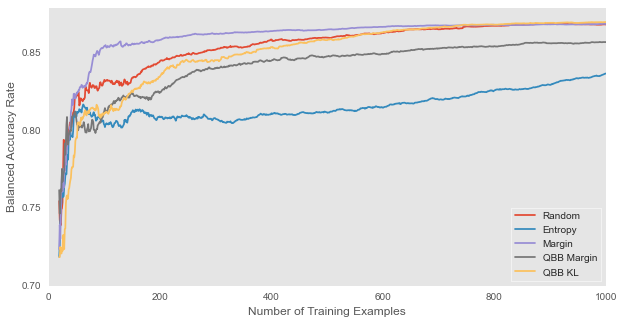

In [8]:
learning_curves = []
for pickle_path in pickle_paths_default:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_default.pdf', bbox_inches='tight')

## Balanced Training Pool

In [17]:
pickle_paths_balanced = ['pickle/05_logistic_active_learning/balanced_random.pickle',
                        'pickle/05_logistic_active_learning/balanced_entropy.pickle',
                        'pickle/05_logistic_active_learning/balanced_margin.pickle',
                        'pickle/05_logistic_active_learning/balanced_qbb_margin.pickle',
                        'pickle/05_logistic_active_learning/balanced_qbb_kl.pickle']

In [ ]:
mclearn.active_learning_experiment(sdss, feature_cols, target_col, logistic_classifier,
    heuristics, committee, pickle_paths_balanced, balanced_pool=True)

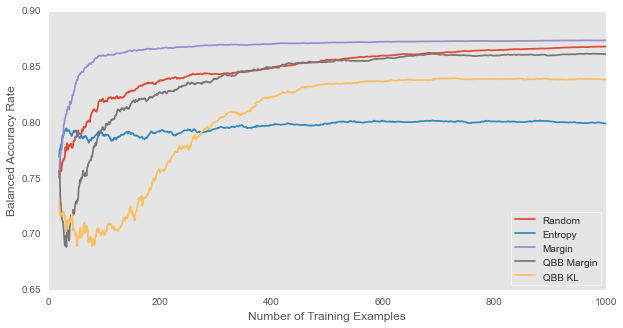

In [18]:
learning_curves = []
for pickle_path in pickle_paths_balanced:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig('plots/lc_active_logistic_balanced.pdf', bbox_inches='tight')